In [11]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
from itertools import permutations, combinations
import scipy
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'

######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
ASC_subtype_df_loc = '../../data/vdj/ASC_subtypes.tab'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = '../figures/paper figures'
######################## ############ ################################
from tb_colormaps import *
plt.style.use('./bursa.mplstyle')

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read data

In [12]:
df = pd.read_table(full_df_loc, low_memory=False, usecols = ['sample_uid_vdj',
                                                             'sample_uid',
                                                             'sample_uid_gex',
                                                             'cb',
                                                             'c_call',
                                                             'vdj_sequence',
                                                             'v_identity',
                                                             'v_mismatch',
                                                             'n_umis',
                                                             'lineage_id',
                                                             'donor', 
                                                             'tissue',
                                                             'cycling',
                                                             'correlation_cycling',
                                                             'probable_hq_single_b_cell',
                                                             'multiplet_status',
                                                             'probable_hq_single_b_cell',
                                                             'is_ambient_source',
                                                             'vdj_is_from_ambient',
                                                             'Immune_All_Low_predicted_labels'])
df = df[(df.vdj_sequence.notna()) & (df.lineage_id.notna())]
df['donor_tissue'] = df['donor'] + "_" + df['tissue']

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs"
}

ASC_subtype_df = pd.read_table(ASC_subtype_df_loc)

ASC_subtype_df.columns=['barcode','subtype','sample_uid']
ASC_subtype_df['cb'] = ASC_subtype_df.barcode.str.split("-").map(lambda x: x[0])
ASC_subtype_df['cb_suid'] = ASC_subtype_df['cb'] + "_" + ASC_subtype_df['sample_uid']
ASC_subtype_dict = ASC_subtype_df.set_index('cb_suid')['subtype'].to_dict()
df['cb_suid'] = df['cb'] + "_" + df['sample_uid']
df['ASC_subtype'] = df.cb_suid.map(ASC_subtype_dict)
df['celltype'] = df['Immune_All_Low_predicted_labels'].copy()
df['celltype'] = df.celltype.map(lambda x: celltypist_simpler.get(x,x))
df.loc[df.ASC_subtype.notna(), 'celltype'] = df['ASC_subtype']


df_clean = df[(df.probable_hq_single_b_cell==True) & (df.multiplet_status==1) & ~(df.vdj_is_from_ambient == True).astype(bool)].copy()
naive =df_clean.Immune_All_Low_predicted_labels == 'Naive B cells'
unswitched = df_clean.c_call.isin(['IGHM','IGHD'])
permitted = (naive & unswitched) | ~(naive.astype(bool))
df_clean = df_clean[permitted]
df_clean = df_clean[~df_clean.celltype.str.startswith('Plasma')]


In [ ]:
lineage_sizes = df.groupby(['donor','lineage_id']).size().to_dict()
df['lineage_size'] = df.apply(lambda x: lineage_sizes[(x.donor, x.lineage_id)],
                             axis=1)
lineage_sizes = df_clean.groupby(['donor','lineage_id']).size().to_dict()
df_clean['lineage_size'] = df_clean.apply(lambda x: lineage_sizes[(x.donor, x.lineage_id)],
                             axis=1)

In [ ]:
v_mismatch_dict = df[['vdj_sequence', 
                      'v_mismatch']].drop_duplicates(ignore_index=True).set_index('vdj_sequence')
v_mismatch_dict = v_mismatch_dict.to_dict()['v_mismatch']

celltype_dict = df_clean.groupby(['donor','lineage_id','vdj_sequence'])['celltype'].agg(list)
celltype_dict = celltype_dict.to_dict()
all_celltypes = df_clean.celltype.value_counts()
all_celltypes = all_celltypes[all_celltypes>10]

tissue_dict = df.groupby(['donor','lineage_id','vdj_sequence'])['tissue'].agg(list)
tissue_dict = tissue_dict.to_dict()
all_tissues = df.tissue.value_counts()
print(all_tissues)

isotype_dict = df.groupby(['donor','lineage_id','vdj_sequence'])['c_call'].agg(list)
isotype_dict = isotype_dict.to_dict()
all_isotypes = df.c_call.value_counts()
all_isotypes = all_isotypes[all_isotypes>300]
print(all_isotypes)


BM    465824
LN    310026
SP    204151
PB    180736
Name: tissue, dtype: int64
IGHM     451812
IGHA1    217365
IGHG1    214664
IGHG2    115329
IGHD      90095
IGHA2     34071
IGHG3     30323
IGHG4      6469
IGHE        337
Name: c_call, dtype: int64


In [ ]:
test_variables = [('tissue', tissue_dict, all_tissues, tissue_colors),
                  ('celltype', celltype_dict, all_celltypes, bcelltype_colors_alt),
                  ('isotype', isotype_dict, all_isotypes, IGH_colors)]

# Drop down to unique vdj sequences

In [ ]:
df = df[['vdj_sequence','donor','lineage_id', 'v_mismatch']].drop_duplicates(ignore_index=True)
df['lineage_uid'] = df['donor'] + "_" + df['lineage_id'].astype(str)

# Analyze distribution within lineage

In [ ]:
new_df = df.copy()

for variable_tuple in test_variables:
    variable, variable_dict, all_variable_counts, palette = variable_tuple
    for label in all_variable_counts.index:
        new_df[label] = new_df.apply(lambda x: label in variable_dict.get((x.donor,
                                                                x.lineage_id,
                                                                x.vdj_sequence), []), axis=1)
new_df = new_df[(~new_df['Naive B cells'])|(new_df.v_mismatch<5)]
lineage_sizes = new_df.groupby('lineage_uid').size()
mut_min_max = new_df.groupby(['lineage_uid'])['v_mismatch'].agg(['min','max','mean','median'])
new_df['lineage_size'] = new_df.lineage_uid.map(lineage_sizes)
new_df['lineage_size_rank'] = new_df.groupby(['donor'])['lineage_size'].rank(method='first')#.astype(str)
print("Started with ", new_df.lineage_uid.nunique(), "lineages in entire dataset")
new_df = new_df[new_df.lineage_size > 2]
print("Retaining only lineages with at least 3 unique sequences, a total of ", new_df.lineage_uid.nunique(), "lineages")

new_df['v_mismatch'] = new_df.vdj_sequence.map(v_mismatch_dict)
new_df['hm_rank']= new_df.groupby(['lineage_uid'])['v_mismatch'].rank(method='first')
new_df['hm_level'] = new_df.apply(lambda x:
                                                 (x.v_mismatch - mut_min_max.loc[x.lineage_uid,'min'])/
                                                  ( mut_min_max.loc[x.lineage_uid,'max'] - 
                                                   mut_min_max.loc[x.lineage_uid,'min']), 
                                                  axis=1)
new_df['hm_diff'] = new_df.apply(lambda x:
                                                 (x.v_mismatch - mut_min_max.loc[x.lineage_uid,'min']), 
                                                  axis=1)

Started with  542912 lineages in entire dataset
Retaining only lineages with at least 3 unique sequences, a total of  26859 lineages


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_4313/1041516321.py:21: RuntimeWarning: invalid value encountered in double_scalars
  (x.v_mismatch - mut_min_max.loc[x.lineage_uid,'min'])/


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_4313/1745290341.py:60: RuntimeWarning: invalid value encountered in divide
  -np.log(subset_min/data_fraction)/np.log(2),
/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_4313/1745290341.py:61: RuntimeWarning: invalid value encountered in divide
  -np.log(subset_max/data_fraction)/np.log(2),
/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_4313/1745290341.py:60: RuntimeWarning: invalid value encountered in divide
  -np.log(subset_min/data_fraction)/np.log(2),
/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_4313/1745290341.py:61: RuntimeWarning: invalid value encountered in divide
  -np.log(subset_max/data_fraction)/np.log(2),
/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_4313/1745290341.py:60: RuntimeWarning: invalid value encountered in divide
  -np.log(subset_min/data_fraction)/np.log(2),
/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_4313/1745290341.py:61: RuntimeWarnin

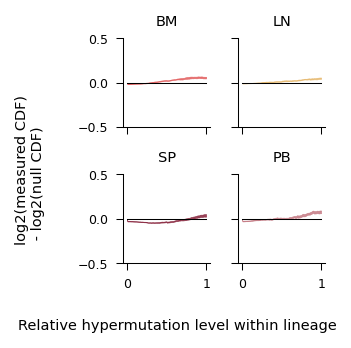

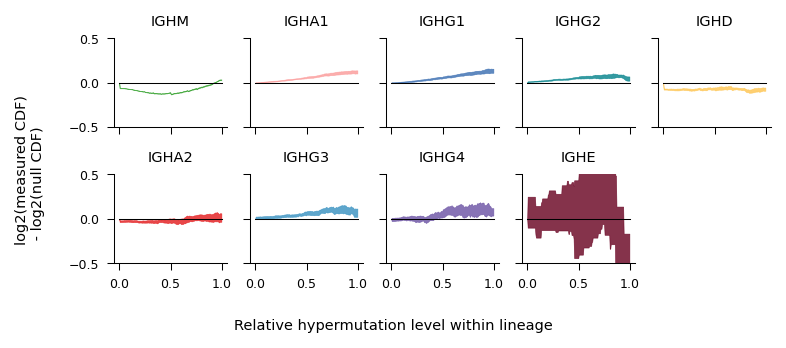

In [ ]:
layout = {'tissue':(2,2),
          'celltype':(2,4),
          'isotype':(2,5)}

xvals = np.linspace(-0.001,1,200)

def calculate_complementary_cdf(xvals, yvals):
    complementary_cdf = np.asarray([(yvals>x).sum() for x in xvals])
    complementary_cdf = complementary_cdf/complementary_cdf[0]
    return complementary_cdf

for stat in ['hm_level']:
    for variable_tuple in test_variables:
        variable, variable_dict, all_variable_counts, palette = variable_tuple
        nvars = len(all_variable_counts)
        nrows, ncols = layout[variable]
        fig, ax = plt.subplots(nrows,ncols, figsize=(1*ncols+0.25,1*nrows+0.25), sharex=True, sharey=True)
        ax = ax.flatten()
        if len(ax) > len(all_variable_counts):
            for it in range(len(all_variable_counts), len(ax)):
                ax[it].remove()
        for i, label in enumerate(all_variable_counts.index):
            axes = ax[i]
            bbox = axes.get_position()
            x, y, w, h = bbox.bounds

            inset_x, inset_y = x + w*0.6, y + h*0.6
            inset_w, inset_h = w*0.3, h*0.3

            # inset_ax = fig.add_axes([inset_x, inset_y, inset_w, inset_h])
            # inset_ax.tick_params(direction='in', length=0.5, width=1, labelsize=6, pad=1)

            #first calculate data stats and plot 1-1 line with null
            yvals = new_df.loc[new_df[label] & new_df.v_mismatch > 0, stat].values
            data_fraction = calculate_complementary_cdf(xvals, yvals)
            axes.plot(xvals, np.zeros(len(xvals)), color='k', lw=0.5)
            # now plot_permutations
            n = new_df[label].sum()

            weight_dict = ((new_df.groupby(['lineage_uid'])[label].sum()+0.001)/(new_df.groupby(['lineage_uid']).size()+0.001)).to_dict()
            weights = new_df.lineage_uid.map(weight_dict)
            subsets = []
            for it in range(20):
                random_subset = new_df.sample(n, weights=weights)
                random_subset = new_df[new_df.v_mismatch > 0].sample(n, weights=weights)

                resample_fraction = calculate_complementary_cdf(xvals, random_subset[stat].values)
                subsets.append(resample_fraction)
            
            subsets = np.asarray(subsets)
            subset_min = np.min(subsets, axis=0)
            subset_max = np.max(subsets, axis=0)
            axes.fill_between(xvals, 
                              -np.log(subset_min/data_fraction)/np.log(2), 
                              -np.log(subset_max/data_fraction)/np.log(2), 
                               color=palette[label], 
                               alpha=0.8, 
                               lw=0.3)

            ax[i].set_title(f"{label}", fontsize=7)
            ax[i].set_xlabel('')
            ax[i].set_ylabel('')
            if variable == 'celltype':
                ax[i].set_ylim([-2,2])
            else:
                ax[i].set_ylim([-0.5,0.5])
            # inset_ax.set_xlabel('')
            # inset_ax.set_ylabel('')
        for axes in ax:
            sns.despine(ax=axes)
        fig.supylabel('log2(measured CDF) \n - log2(null CDF)', fontsize=7)
        fig.supxlabel("Relative hypermutation level within lineage", fontsize=7)
        fig.tight_layout()
        fig.savefig(f'{FIGURE_OUTDIR}/Figure5_{variable}_distributions_within_lineage.pdf', bbox_inches='tight')

In [ ]:
order = {"Naive B cells":0,
         "Memory B cells":1,
         'GC B cells':2,
         "ABCs":3, 
         "ASC-1":4, 
         "ASC-2":5, 
         "ASC-3":6, 
         "ASC-4":7}
order.update({'PB':0,
              'BM':1,
              'SP':2,
              'LN':3})

order.update({'IGHM':0,
             'IGHD':1,
              'IGHA1':2,
              'IGHA2':3,
              'IGHG1':4,
              'IGHG2':5,
              'IGHG3':6,
              'IGHG4':7,
              'IGHE':8})
bins = {'v_mismatch':np.linspace(0,100,40)}

stat='v_mismatch'

fig, ax = plt.subplots(3,1, figsize=(3.5,4.5), sharex=True, sharey=True)

for ax_it, variable_tuple in enumerate(test_variables):
        variable, variable_dict, all_variable_counts, palette = variable_tuple
        axes = ax[ax_it]

        for i, label in enumerate(all_variable_counts.index):
            target_lineages = new_df.groupby('lineage_uid')[label].sum() > 0
            target_lineages = target_lineages[target_lineages].index.values
            target_lineages = new_df.lineage_uid.isin(target_lineages)
            # print(label, target_lineages.shape)
            if target_lineages.sum()>0:
                legend_label = label#.strip("s") + ""
                sns.ecdfplot(new_df[target_lineages & new_df.v_mismatch >0], 
                            x=stat, 
                            complementary=True, 
                            ax=axes,
                            label=legend_label, 
                            color=palette[label],
                            lw=0.5)
                axes.set_xlim([0,80])

        # Get current legend handles and labels
        handles, labels = axes.get_legend_handles_labels()

        # Step 4: Sort handles and labels based on desired order
        handles, labels = zip(*sorted(zip(handles, labels), key=lambda t: order[t[1]]))

        # Step 5: Create a new legend with sorted handles and labels
        axes.legend(handles, labels, loc='upper left', frameon=False, bbox_to_anchor=(1.0,1.1), title=variable)
        axes.set_xlabel('Number of IGHV hypermutations')
        axes.set_ylabel('Proportion\ngreater')
        sns.despine(fig)
        fig.tight_layout()
        fig.savefig(f'{FIGURE_OUTDIR}/Figure5_cells_in_lineage_containing_v_mismatch_wide.pdf', bbox_inches='tight')

In [ ]:
# df = df[['vdj_sequence','donor','lineage_id', 'v_mismatch','c_call','tissue']].drop_duplicates(ignore_index=True)
